## 1.Environment Setup & Imports
Run this first to install necessary libraries, mount your Google Drive, and import packages.

In [ ]:
# === 1.1 Install Dependencies ===
!pip install numpy==1.26.4
!pip install scikit-surprise

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2555843 sha256=3f92dfe5be5a70c97e4c92faf397c69bdea7b38433acfd30c55be25e565ef3ce
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [ ]:
# === 1.3 Import Libraries ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

# Define path
data_path = '../datasets/student_grade.csv'

Current working directory: /content/drive/MyDrive/Research Project Data


## 2.Data Loading & Preprocessing
This section handles reading the CSV, transforming it from "Wide" to "Long" format, cleaning invalid grades, and filtering specifically for 'INT' courses.

In [ ]:
# Check if file exists
if not os.path.exists(data_path):
    print(f"Error: The file '{data_path}' was not found.")
else:
    print("File found. Loading data...")

    # === 2.1 Load Data ===
    df = pd.read_csv(data_path, low_memory=False)

    # === 2.2 Transform Data (Wide to Long) ===
    id_vars = ['student_id']
    df_long = pd.melt(df, id_vars=id_vars, var_name='course', value_name='grade')

    # === 2.3 Clean Data ===
    # Convert grade to numeric and remove invalid/empty grades
    df_long['grade'] = pd.to_numeric(df_long['grade'], errors='coerce')
    df_long_cleaned = df_long[(df_long['grade'] > 0.0) & (df_long['grade'].notna())].copy()

    # === 2.4 Filter for 'INT' Courses Only ===
    # This ensures the model only learns from INT courses
    df_long_filtered = df_long_cleaned[df_long_cleaned['course'].astype(str).str.startswith('INT')].copy()

    print(f"--- Data Preparation Complete ---")
    print(f"Total records after cleaning: {len(df_long_cleaned)}")
    print(f"Filtered to INT courses only: {len(df_long_filtered)}")
    display(df_long_filtered)


File found. Loading data...
--- Data Preparation Complete ---
Total records after cleaning: 43104
Filtered to INT courses only: 17468


,student_id,course,grade
30174,A246,INT102 WEB TECHNOLOGY,1.5
31446,A632,INT102 WEB TECHNOLOGY,3.0
31447,A086,INT102 WEB TECHNOLOGY,4.0
31448,A662,INT102 WEB TECHNOLOGY,4.0
31449,A066,INT102 WEB TECHNOLOGY,2.5
...,...,...,...
597291,A385,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,3.5
597293,A424,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
597306,A111,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
597308,A627,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5


In [ ]:
df

In [ ]:
df_long_filtered

## 3.Data

In [ ]:
# === 3.1 Load Data into Surprise Dataset ===
# Define rating scale (assuming grades are 1.0 to 4.0)
reader = Reader(rating_scale=(1, 4))
data = Dataset.load_from_df(df_long_filtered[['student_id', 'course', 'grade']], reader)

## Parameter Tuning

In [ ]:
# 1. กำหนดช่วงตัวแปรที่จะลอง (Parameter Grid)
param_grid = {
    'n_factors': [100,110, 150],    # จำนวน Latent Factors (ความซับซ้อนของโมเดล)
    'n_epochs': [140,160,170],           # จำนวนรอบการเรียนรู้
    'lr_all': [0.005, 0.01 , 0.01],        # Learning Rate (อัตราการเรียนรู้)
    'reg_all': [0.02, 0.05, 0.1],    # Regularization (บทลงโทษกัน Overfit)
}
# 2. สั่งรัน Grid Search (ขั้นตอนนี้จะนานหน่อย เพราะมันทำ Cross Validation ให้ด้วย)
# cv=5 แปลว่าแบ่งเทส 5 รอบ ในแต่ละชุดตัวแปร
print("--- Starting Grid Search (This may take a while) ---")
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5,joblib_verbose=10)
gs.fit(data) # ใช้ตัวแปร 'data' ตัวเต็มจาก Section 3.1
print("Best RMSE Score:", gs.best_score['rmse'])
print("Best Parameters (RMSE):", gs.best_params['rmse'])
print("Best MAE Score:", gs.best_score['mae'])
print("Best Parameters (MAE):", gs.best_params['mae'])


--- Starting Grid Search (This may take a while) ---


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    9.8s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:   15.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   22.2s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:   30.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   39.8s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   51.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done 144 tasks      | elapsed:  3.4min
[Parallel(n_jobs=1)]: Do

Best RMSE Score: 0.5488962329491889
Best Parameters (RMSE): {'n_factors': 100, 'n_epochs': 140, 'lr_all': 0.01, 'reg_all': 0.05}
Best MAE Score: 0.43309897013809523
Best Parameters (MAE): {'n_factors': 100, 'n_epochs': 140, 'lr_all': 0.01, 'reg_all': 0.05}


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 10.9min finished


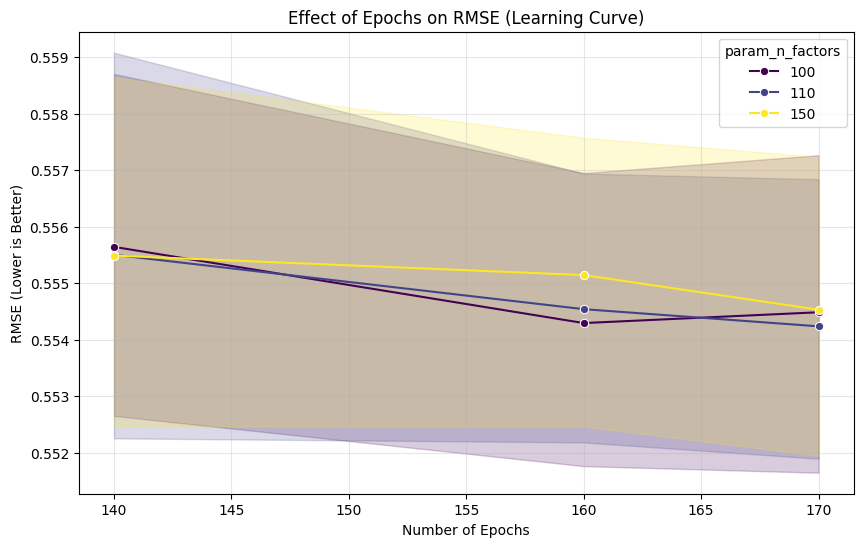

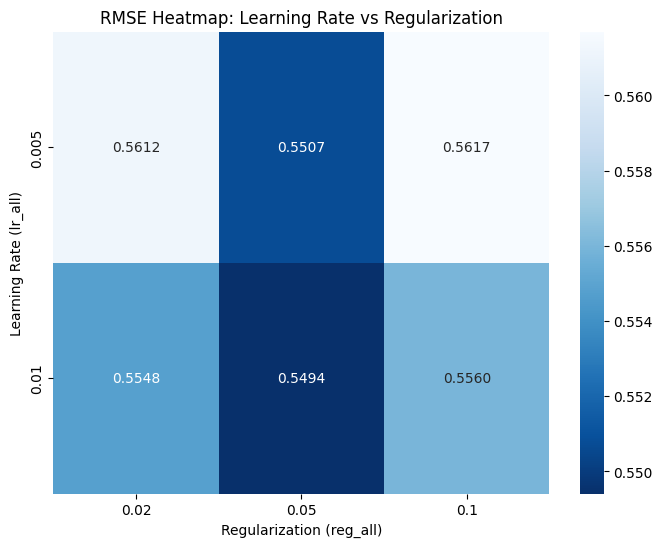

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. แปลงผลลัพธ์ทั้งหมดจาก Grid Search มาเป็น DataFrame เพื่อให้พลอตกราฟง่าย
results_df = pd.DataFrame.from_dict(gs.cv_results)

# -------------------------------------------------------
# Graph 1: Effect of Epochs (Learning Curve)
# ดูว่า "จำนวนรอบการเรียนรู้" ส่งผลต่อ Error อย่างไร
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# แกน X: จำนวน Epochs
# แกน Y: ค่า Error (RMSE)
# Hue (สีเส้น): แยกตามจำนวน Factors (ความซับซ้อนของโมเดล)
sns.lineplot(data=results_df, x='param_n_epochs', y='mean_test_rmse',
             hue='param_n_factors', marker='o', palette='viridis')

plt.title('Effect of Epochs on RMSE (Learning Curve)')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE (Lower is Better)')
plt.grid(True, alpha=0.3)
plt.show()

# -------------------------------------------------------
# Graph 2: Heatmap (Learning Rate vs Regularization)
# กราฟนี้สำคัญมาก! เอาไว้ดู "Sweet Spot" หรือจุดที่ลงตัวที่สุด
# -------------------------------------------------------
# สร้าง Pivot Table เพื่อเตรียมข้อมูลลง Heatmap
# เราจะดูค่าเฉลี่ย RMSE ของคู่ Learning Rate กับ Regularization
pivot_table = results_df.pivot_table(values='mean_test_rmse',
                                     index='param_lr_all',    # แกนตั้ง
                                     columns='param_reg_all') # แกนนอน

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='Blues_r') # Blues_r คือยิ่งเข้มยิ่งค่าน้อย (ดี)

plt.title('RMSE Heatmap: Learning Rate vs Regularization')
plt.xlabel('Regularization (reg_all)')
plt.ylabel('Learning Rate (lr_all)')
plt.show()